<a href="https://colab.research.google.com/github/tomsiwek/RNN_denoising/blob/main/RNN_ECG_denoiser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Antczak, 2019*

Real dataset used in this research came from Physio-
net PTB diagnostic database [17]. It contains 549 records
from 290 subjects. Signal in database are available for 15
leads. For our purposes, we decided to use a VL lead only.

To use a model in practice, several parameters needs
to be specified. The main goal here is to obtain a signal as
similar to the real data as possible. Morphological param-
eters (ai , bi , θi ) were set for each of P, Q, R, S and T events,
with the same values as in [16]. Frequency and spectral
parameters were also mostly the same, with the exception
of heart rate standard deviation - value of 5 was used.
Moreover, the sampling rate used was 512. The signal had
additive uniform (white) noise with amplitude 0.01. It
was treated as a “base” noise level – a different from the
one being added later for denoising task. A sample of
generated synthetic signal can be seen in figure below.

The signals, be it artificial or real, were preprocessed
by **normalizing them to have a zero mean**. Next, they
were divided into samples 600 datapoints each. Such
number of points corresponds to approximately two ECG
cycles. Such preprocessed datasets were used as expected
outputs during training and testing of networks. The in-
puts signals for networks were produced by adding a
white noise to the reference signal. All metrics were then
calculated on the normalized data.

Pre-training data was artificial dataset used in previous test, with 64 samples per patch. Fine-tuning dataset consisted of 5000 real
training samples and 2000 reals validation samples.

In [ ]:
import numpy as np
import math, random
import matplotlib.pyplot as plt
import csv

%matplotlib inline
np.random.seed(0)

In [ ]:
# Generating a clean sine wave 
def sine(X, signal_freq=60.):
    return np.sin(2 * np.pi * (X) / signal_freq)

# Read ECG data
def read_ecg(filename, col = 1, ADU = 1.0):
    ecg_sig = []
    with open(filename, 'r') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',')
        for row in spamreader:
            ecg_sig.append(float(row[col]))
    return np.array(ecg_sig, dtype="float64")/ADU#/max(ecg_sig)

# Adding uniform noise
def noisy(Y, noise_range=(-0.35, 0.35)):
    noise = np.random.uniform(noise_range[0], noise_range[1], size=Y.shape)
    return Y + noise

# Create a noisy and clean sine wave 
def sample(sample_size, i, data):
    out = np.zeros(sample_size)
    # reading input data
    out = data[:]
    # clipping
    out = out[i*sample_size:(i+1)*sample_size]
    # padding
    inp = noisy(out)
    return inp, out
  
def normalise(sig):
    return sig - np.mean(sig)

# Pad data with zeros to get a number of samples divisble by batch_size
def pad_data(sig, batch_size=64, samp=600):
  actual_batches = sig.size/(batch_size*samp)
  padded_batches = np.ceil(sig.size/(batch_size*samp))
  padded_width = int(padded_batches*batch_size*samp - len(sig))
  padded_sig = np.pad(sig, (0, padded_width),'constant')
  return padded_sig

def scale_translate(sig, tr=0.0, sc=1.0):
  return sig*sc+tr

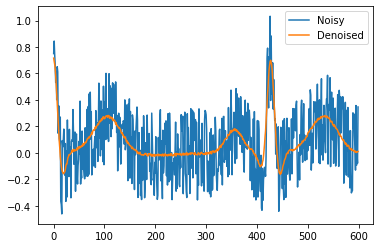

In [ ]:
y_clean = normalise(read_ecg("/content/drive/MyDrive/ecg/ecgsyn_noise_crop.csv", col=0))
X_noisy = noisy(y_clean)
plt.plot(X_noisy[:600], label='Noisy')
plt.plot(y_clean[:600], label ='Denoised')
plt.legend()

In [ ]:
def create_dataset(n_samples, sample_size, data):
    data_inp = np.zeros((n_samples, sample_size))
    data_out = np.zeros((n_samples, sample_size))
    
    for i in range(n_samples):
        sample_inp, sample_out = sample(sample_size, i, data)
        data_inp[i, :] = sample_inp
        data_out[i, :] = sample_out
    return data_inp, data_out


In [ ]:
data_inp, data_out = X_noisy[:2000*600], y_clean[:2000*600]
train_inp, train_out = data_inp[:].reshape(2000,600), data_out[:].reshape(2000,600)
data_inp, data_out = X_noisy[2000*600:4000*600], y_clean[2000*600:4000*600]
test_inp, test_out = data_inp[:].reshape(2000,600), data_out[:].reshape(2000,600)
print(train_inp.shape, train_out.shape, test_inp.shape, test_out.shape)

(2000, 600) (2000, 600) (2000, 600) (2000, 600)


In [ ]:
# translacja, skalowanie
scales = [0.9, 0.75, 0.5, 0.25, 0.1]
translations = [-1.0, -0.9, -0.75, -0.5, -0.25, -0.1, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0]
train_inp_aug = np.zeros((8000, 600))
train_out_aug = np.zeros((8000, 600))
for i, (fragm_inp, fragm_out) in enumerate(zip(np.repeat(train_inp,4,axis=0), np.repeat(train_out,4,axis=0))):
  tr = random.choice(translations)
  sc = random.choice(scales)
  train_inp_aug[i] = scale_translate(fragm_inp, tr, sc)
  train_out_aug[i] = scale_translate(fragm_out, tr, sc)
test_inp_aug = np.zeros((8000, 600))
test_out_aug = np.zeros((8000, 600))
for i, (fragm_inp, fragm_out) in enumerate(zip(np.repeat(test_inp,4,axis=0), np.repeat(test_out,4,axis=0))):
  tr = random.choice(translations)
  sc = random.choice(scales)
  test_inp_aug[i] = scale_translate(fragm_inp, tr, sc)
  test_out_aug[i] = scale_translate(fragm_out, tr, sc)

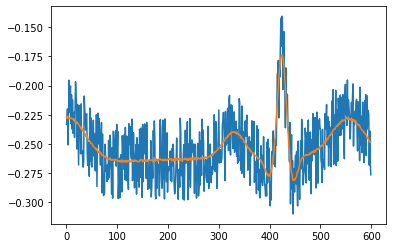

In [ ]:
sign=213
plt.plot(train_inp_aug[sign])
plt.plot(train_out_aug[sign])
plt.show()

In [ ]:
print(train_inp.shape, train_out.shape, test_inp.shape, test_out.shape)

(2000, 600) (2000, 600) (2000, 600) (2000, 600)


In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.tensorboard import SummaryWriter

In [ ]:
shuffle_en = False
inp_train_loader = torch.utils.data.DataLoader(train_inp, batch_size=64, shuffle=shuffle_en)
out_train_loader = torch.utils.data.DataLoader(train_out, batch_size=64, shuffle=shuffle_en)
inp_test_loader = torch.utils.data.DataLoader(test_inp, batch_size=64, shuffle=shuffle_en)
out_test_loader = torch.utils.data.DataLoader(test_out, batch_size=64, shuffle=shuffle_en)

In [ ]:
bidirectional = False
if bidirectional:
    num_directions = 2
else:
    num_directions = 1
class CustomRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_dense, n_recurrent, dropout=False, lstm_do=0.25, relu_do=0.1):
        super(CustomRNN, self).__init__()
        self.dropout_en = dropout
        self.rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size, 
                          batch_first=True, bidirectional=bidirectional, num_layers=n_recurrent)
        self.dropout_lstm = nn.Dropout(lstm_do)
        self.dense = nn.ModuleList()
        for i in range(n_dense):
          self.dense.append(nn.Linear(hidden_size*num_directions, hidden_size*num_directions))
        self.out = nn.Linear(hidden_size*num_directions, output_size, )
        self.dropout_relu = nn.Dropout(relu_do)
        self.act = nn.ReLU()
    def forward(self, x):
        pred, _ = self.rnn(x)
        if self.dropout_en:
          pred = self.dropout_lstm(pred)
        # pred = self.act(pred)
        for layer in self.dense[:-1]:
          if self.dropout_en:
            pred = self.act(self.dropout_relu(layer(pred)))
          else:
            pred = self.act(layer(pred))
        pred = self.out(pred)
        return pred

model = CustomRNN(1, 64, 1, 3, 1, dropout=True, lstm_do=0.25, relu_do=0.1)
print(model)

CustomRNN(
  (rnn): LSTM(1, 64, batch_first=True)
  (dropout_lstm): Dropout(p=0.25, inplace=False)
  (dense): ModuleList(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=64, bias=True)
  )
  (out): Linear(in_features=64, out_features=1, bias=True)
  (dropout_relu): Dropout(p=0.1, inplace=False)
  (act): ReLU()
)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
learning_rate=1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_func = nn.MSELoss()

model = model.to(device)

In [ ]:
# initialize hidden and cell state
def hidden_state_init(stack_num, bsz, hidden):
    hw = torch.empty(stack_num, bsz, hidden)
    cw = torch.empty(stack_num, bsz, hidden)
    h_state = torch.nn.init.xavier_uniform_(hw)
    c_state = torch.nn.init.xavier_uniform_(cw)
    return h_state,c_state

def train_one_epoch(epoch, x_train, y_train):
    running_loss = 0.

    for i, data in enumerate(zip(x_train, y_train)):
      inp, out = data
      inp_t = Variable(inp.reshape(inp.shape[0], -1, 1), requires_grad=True).float().to(device)
      out_t = Variable(out.reshape(out.shape[0], -1, 1)).float().to(device)
      optimizer.zero_grad()
      pred = model(inp_t)
      loss = loss_func(pred, out_t)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
    return running_loss / i

def train(nepochs, x_train, y_train, x_val, y_val, mode="training"):
  history = []
  writer = SummaryWriter()
  for epoch in range(nepochs):
    print('EPOCH {}:'.format(epoch + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch, x_train, y_train)

    # We don't need gradients on to do reporting
    model.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(zip(x_val, y_val)):
      vinp, vout = vdata
      vinp_t = Variable(vinp.reshape(vinp.shape[0], -1, 1), requires_grad=True).float().to(device)
      vout_t = Variable(vout.reshape(vout.shape[0], -1, 1)).float().to(device)
      vpred = model(vinp_t)
      vloss = loss_func(vpred, vout_t)
      running_vloss += vloss.item()

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
    history.append([epoch, avg_loss, avg_vloss])
    writer.add_scalars("Loss/{}".format(mode),{'train': avg_loss, 'valid': avg_vloss}, epoch+1)
  writer.flush()
  return np.array(history)

EPOCH 1:
LOSS train 0.03354935606400813 valid 0.029289559402968735
EPOCH 2:
LOSS train 0.030006578312285485 valid 0.02704873721813783
EPOCH 3:
LOSS train 0.028392031127887386 valid 0.025690281647257507
EPOCH 4:
LOSS train 0.02657521708357719 valid 0.02292745071463287
EPOCH 5:
LOSS train 0.022635699039505373 valid 0.016850339074153453
EPOCH 6:
LOSS train 0.01548079767775151 valid 0.010844185831956565
EPOCH 7:
LOSS train 0.010868759825825691 valid 0.007484686590032652
EPOCH 8:
LOSS train 0.008472274207780439 valid 0.006122656894149259
EPOCH 9:
LOSS train 0.00759100615076961 valid 0.005736568826250732
EPOCH 10:
LOSS train 0.00723159002260335 valid 0.0055627007386647165
EPOCH 11:
LOSS train 0.006955200415705481 valid 0.005413873412180692
EPOCH 12:
LOSS train 0.0067312278063787565 valid 0.005282776124658994
EPOCH 13:
LOSS train 0.006553544873191464 valid 0.005175986356334761
EPOCH 14:
LOSS train 0.0063945890043772035 valid 0.005091745100799017
EPOCH 15:
LOSS train 0.006280187817831193 valid

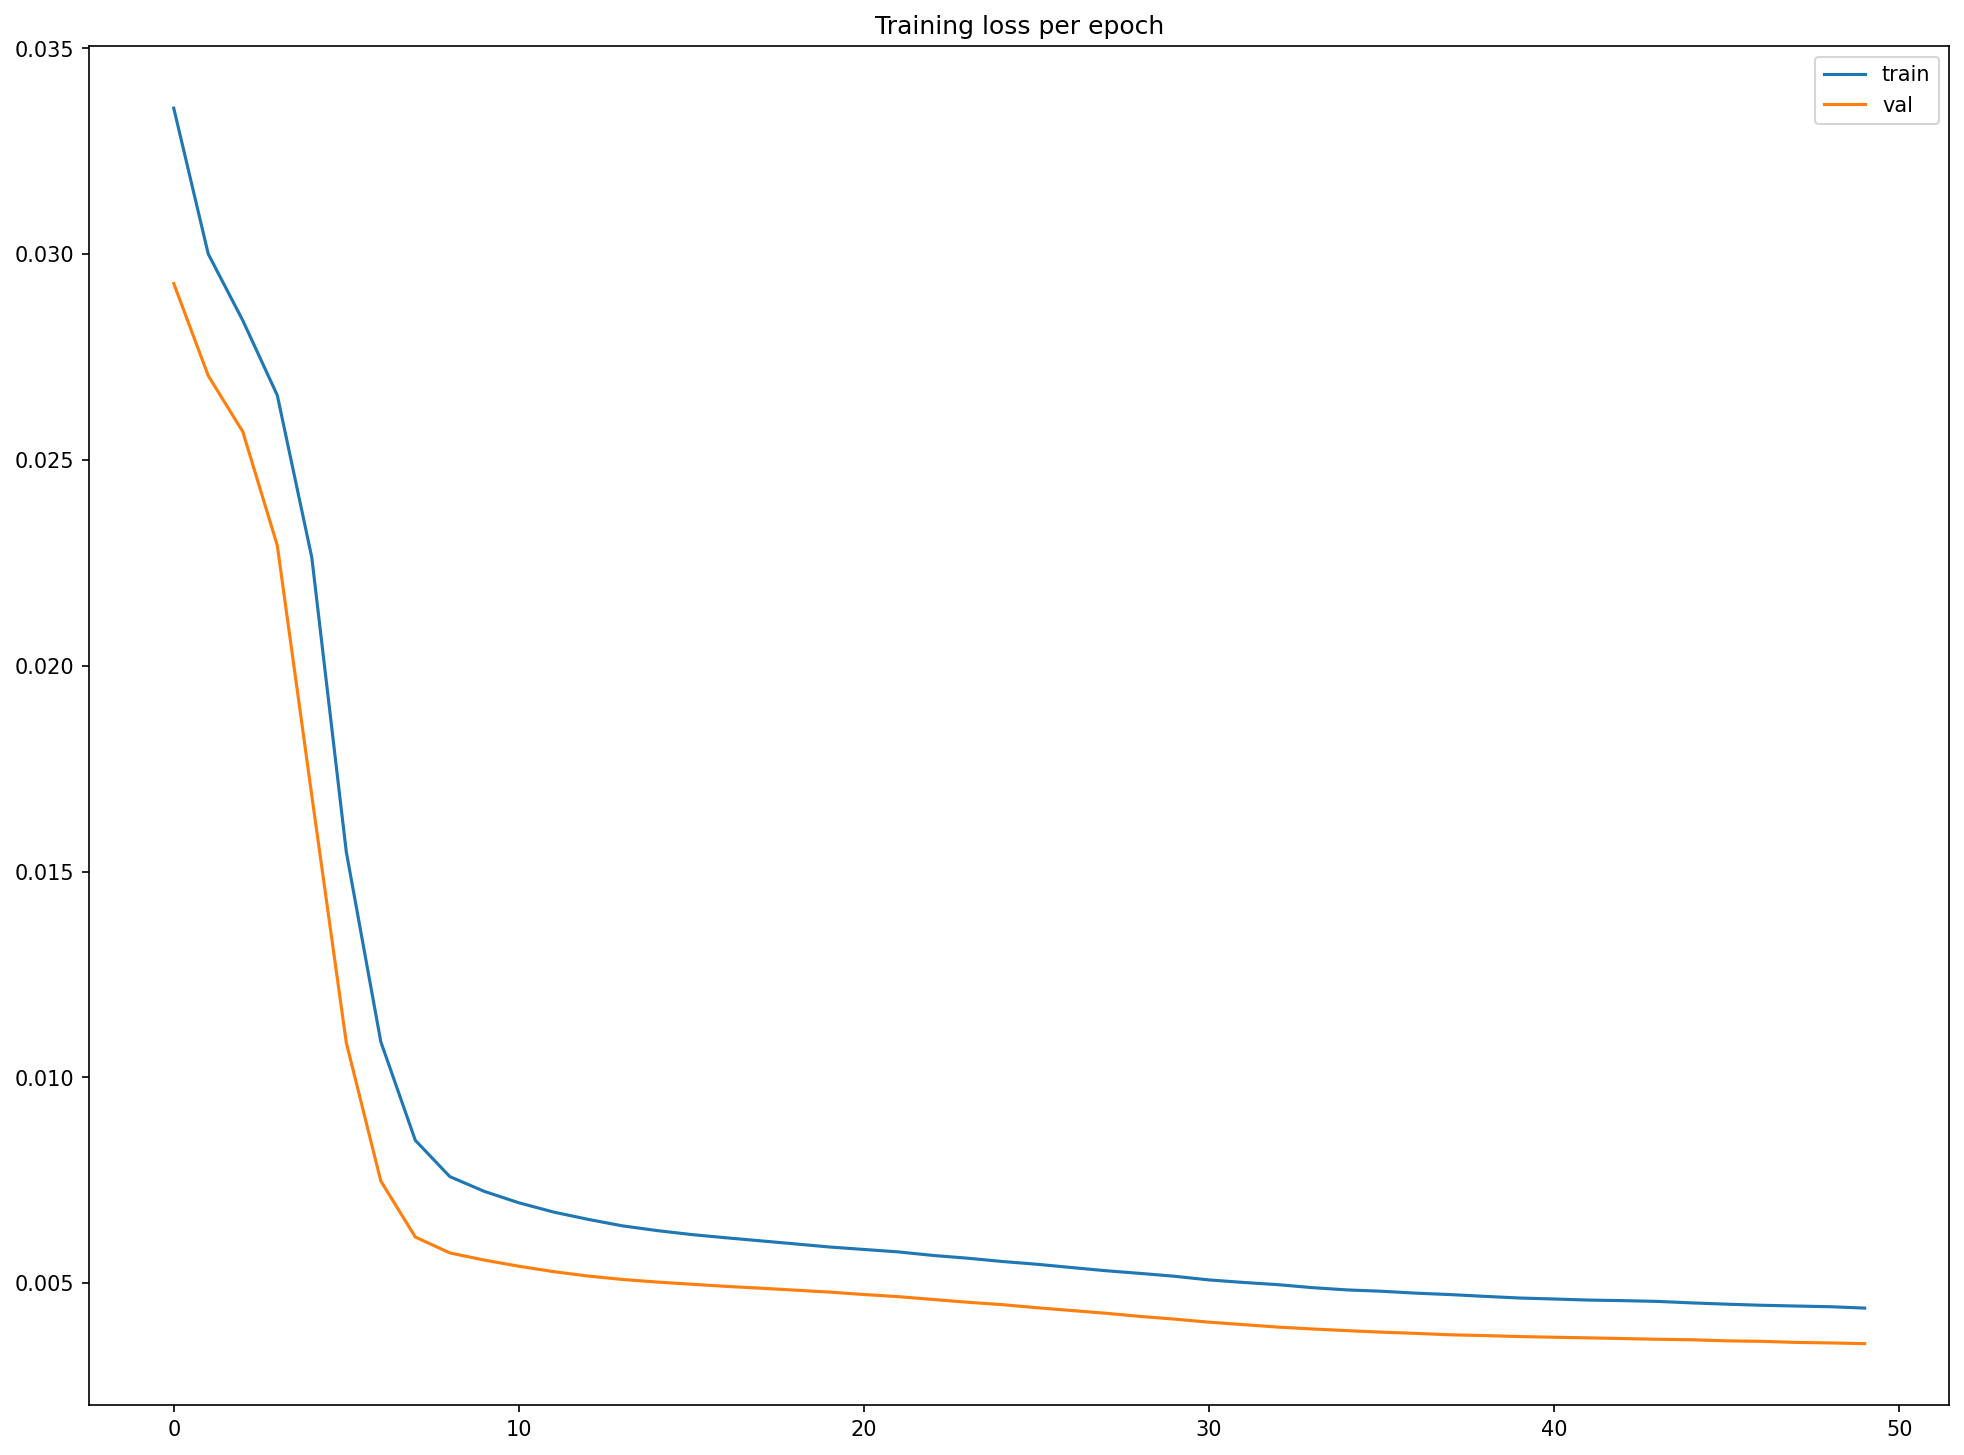

In [ ]:
hist1 = train(50, inp_train_loader, out_train_loader, inp_test_loader, out_test_loader, "training")
plt.figure(figsize=(16, 12), dpi=150)
plt.title('Training loss per epoch')
plt.plot(hist1[:,1], label="train")
plt.plot(hist1[:,2], label="val")
plt.legend()
plt.show()

In [ ]:
for val in hist1[:,2]:
  print(val)

0.029289559402968735
0.02704873721813783
0.025690281647257507
0.02292745071463287
0.016850339074153453
0.010844185831956565
0.007484686590032652
0.006122656894149259
0.005736568826250732
0.0055627007386647165
0.005413873412180692
0.005282776124658994
0.005175986356334761
0.005091745100799017
0.005029704174376093
0.004976328564225696
0.004924456574372016
0.004879940752289258
0.004833246784983203
0.004785638418979943
0.004726209735963494
0.004673807168728672
0.004606361879268661
0.004538752269581892
0.004480542687815614
0.004406337655382231
0.004338524333434179
0.004271986981621012
0.004194437846308574
0.004128677312110085
0.004054013654240407
0.003994760707428213
0.003934575455787126
0.003888715924404096
0.003848898835713044
0.0038115456627565436
0.003781672778131906
0.0037475716744665988
0.003728689487616066
0.0037045100107206963
0.003688283257361036
0.0036730364518007264
0.0036567421120707877
0.0036391228568390943
0.003626539692049846
0.0036002307388116606
0.003588961626519449
0.00356

In [ ]:
!nvidia-smi

Thu Jun 16 14:15:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   80C    P0    45W /  70W |  13048MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
t_inp = Variable(torch.Tensor(test_inp.reshape((test_inp.shape[0], -1, 1))), requires_grad=True).to(device)
pred_t = model(t_inp)

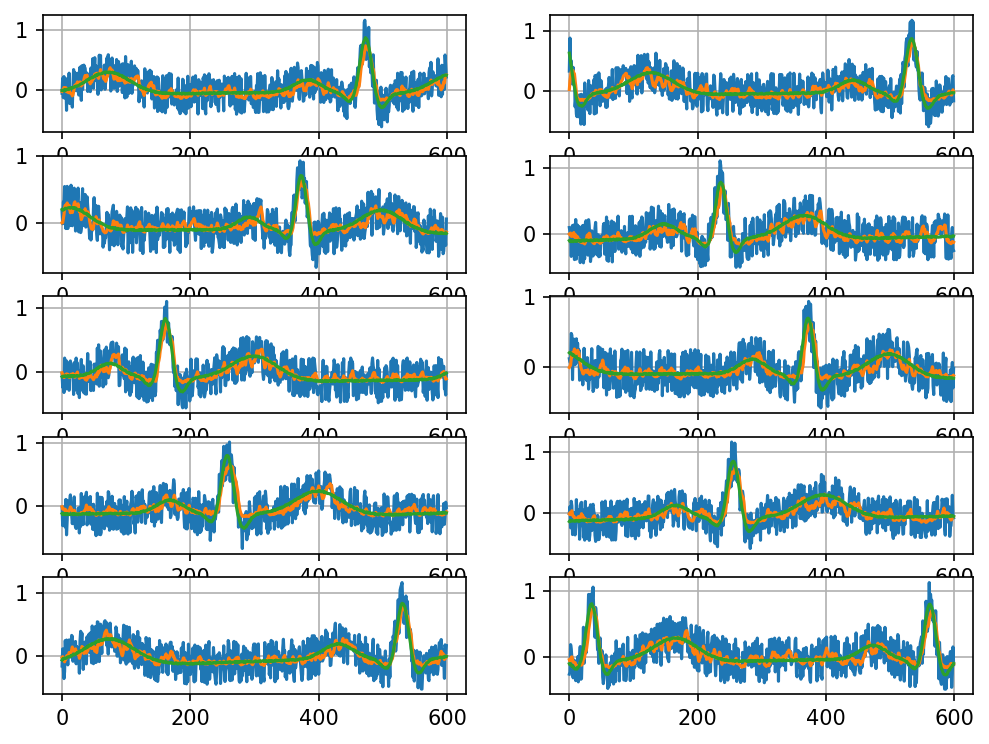

In [ ]:
ns = np.random.randint(0, 2000, size=(10,))
plt.figure(num=None, figsize=(8, 6), dpi=150, facecolor='w', edgecolor='k')
plt.subplot()
for i, n in enumerate(ns):
    plt.subplot(5, 2, i+1)
    plt.plot(test_inp[n], label='Noisy')
    plt.plot(pred_t[n].cpu().data.numpy(), label='Pred')
    plt.plot(test_out[n], label='GT')
    plt.grid()
plt.show()

In [ ]:
# Freeze weights on lstm layer
for (name, module) in model.named_children():
    if name == 'lstm':
        for layer in module.children():
            for param in layer.parameters():
                param.requires_grad = False
    if name == "dropout_lstm":
        for layer in module.children():
            for param in layer.parameters():
                param.requires_grad = False
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
samp_nums = read_ecg("/content/drive/MyDrive/ecg/patients_crop.csv", col=0) # numery próbek od róznych pacjentów -- zero oznacza początek kolejnego pacjenta
new_patients = np.where(samp_nums == 0)[0] # gdzie są początki kolejnego pacjenta
ft_data = read_ecg("/content/drive/MyDrive/ecg/patients_crop.csv", col=5, ADU=1000.0) # Dane o pacjentach
# Normalizujemy pojedynczych pacjentów
ft_data_norm = np.zeros((len(ft_data),))
for p, q in zip(new_patients[:-1], new_patients[1:]):
  print(np.mean(ft_data[p:q]))
  ft_data_norm[p:q] = normalise(ft_data[p:q])

0.0003043489583333307
-0.0004053993055556049
0.00041520833333332093
-8.293402777786439e-05
0.00043763888888887354
6.130208333341831e-05
-0.00012934895833335367
0.0004337871394584894
-0.00044360706409432376
2.4809027777779293e-05
-0.00045504340277784924
0.0014174807242786774
0.0005046364630906566
0.00038988715277778733
-0.005672081377697901
-0.00033643229166666376
0.00017304687499999902
0.00016758680555555293
0.00012844618055553455
-0.0002156250000000126
0.00036451388888889474
-0.00033822916666663015
-0.00038701257861635985
-0.0004601302083333329
-8.46875000000185e-05
-0.00039245659722222877
-1.912326388888614e-05
0.0006248177083333574
0.000281093750000001
0.001444748427672959
0.00034421874999992103
-0.0002984895833332995
0.0002942013888889069
0.0006284461805555366
0.00043441840277780606
0.00020022569444442696
0.00047841145833335454
-0.00013993923611107148


In [ ]:
ft_train_data = ft_data_norm[:5000*600]
ft_test_data = ft_data_norm[5000*600:]
print(ft_train_data.shape, ft_test_data.shape)

(3000000,) (1200000,)


In [ ]:
data_inp, data_out = create_dataset(5000, 600, ft_train_data)
ft_train_inp, ft_train_out = data_inp[:], data_out[:]
data_inp, data_out = create_dataset(2000, 600, ft_test_data)
ft_test_inp, ft_test_out = data_inp[:], data_out[:]
print(ft_train_inp.shape, ft_train_out.shape, ft_test_inp.shape, ft_test_out.shape)

(5000, 600) (5000, 600) (2000, 600) (2000, 600)


In [ ]:
ft_inp_train_loader = torch.utils.data.DataLoader(ft_train_inp, batch_size=64, shuffle=False)
ft_out_train_loader = torch.utils.data.DataLoader(ft_train_out, batch_size=64, shuffle=False)
ft_inp_test_loader = torch.utils.data.DataLoader(ft_test_inp, batch_size=64, shuffle=False)
ft_out_test_loader = torch.utils.data.DataLoader(ft_test_out, batch_size=64, shuffle=False)

EPOCH 1:
LOSS train 0.19059847097676724 valid 0.20592357573332265
EPOCH 2:
LOSS train 0.1604691416813204 valid 0.16747774340910837
EPOCH 3:
LOSS train 0.1265380062544957 valid 0.12309347558766603
EPOCH 4:
LOSS train 0.0923329957951911 valid 0.08437008576584049
EPOCH 5:
LOSS train 0.06717038319374506 valid 0.0580995088967029
EPOCH 6:
LOSS train 0.05132327157144363 valid 0.04120826773578301
EPOCH 7:
LOSS train 0.04098765343093337 valid 0.030043300168472342
EPOCH 8:
LOSS train 0.034060876947851516 valid 0.022855892791994847
EPOCH 9:
LOSS train 0.029405476107524756 valid 0.018478500220226124
EPOCH 10:
LOSS train 0.026329115080909852 valid 0.01598433188337367
EPOCH 11:
LOSS train 0.024413123249243468 valid 0.014552722583175637
EPOCH 12:
LOSS train 0.023213133586045258 valid 0.013712746454984881
EPOCH 13:
LOSS train 0.02238771789826644 valid 0.01319824781967327
EPOCH 14:
LOSS train 0.02195921869805226 valid 0.012767486347001977
EPOCH 15:
LOSS train 0.02158645237199007 valid 0.012466371743357

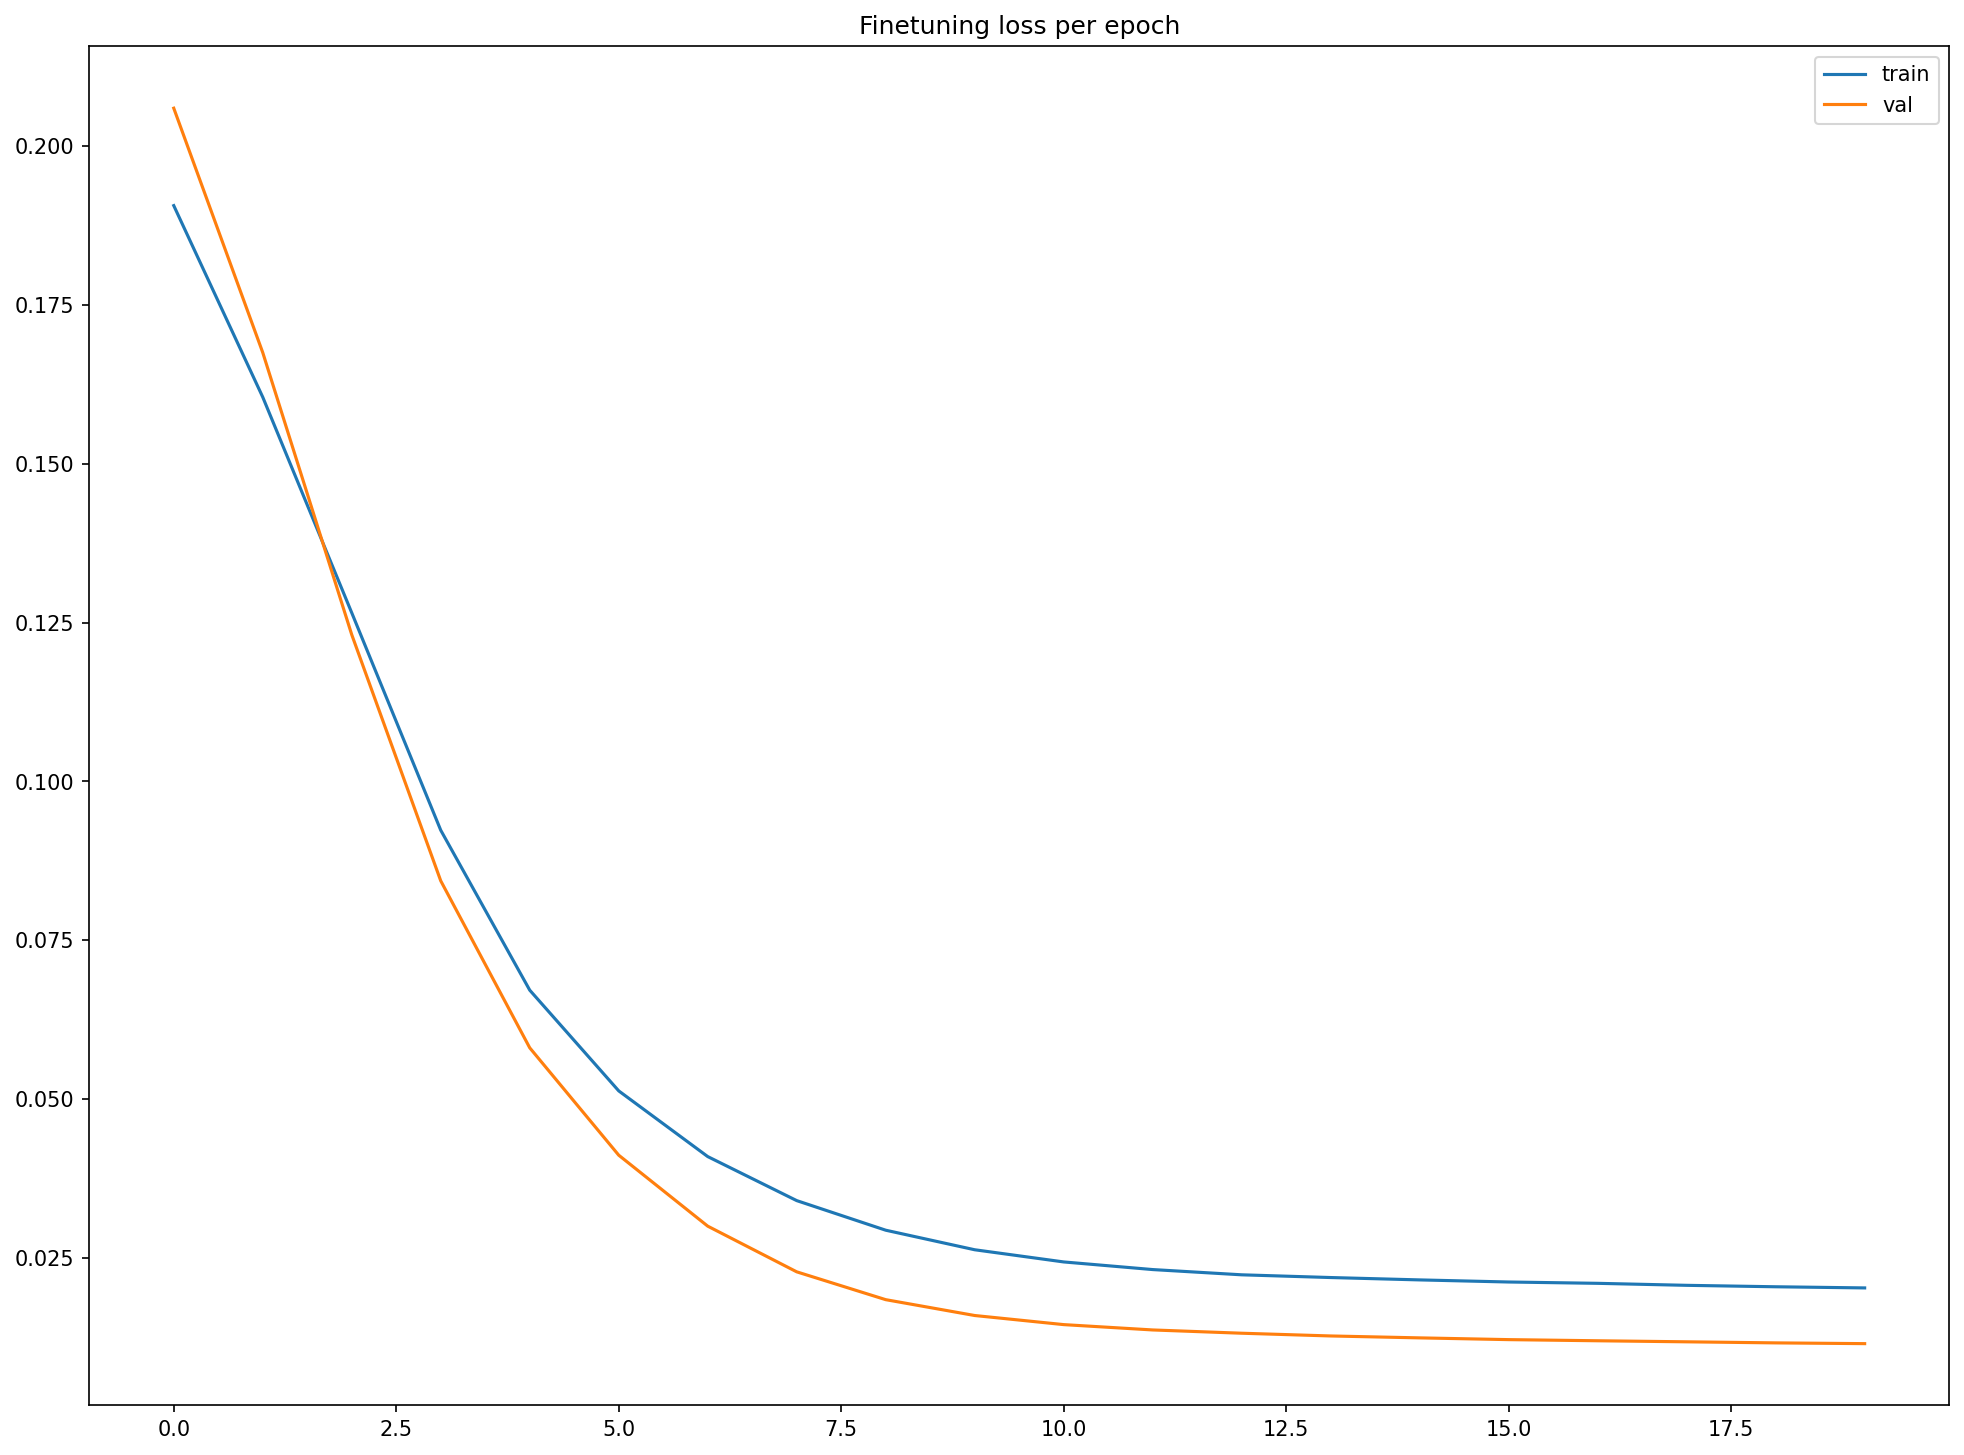

In [ ]:
hist2 = train(20, ft_inp_train_loader, ft_out_train_loader, ft_inp_test_loader, ft_out_test_loader, "finetuning")
plt.figure(figsize=(16, 12), dpi=150)
plt.title('Finetuning loss per epoch')
plt.plot(hist2[:,1], label="train")
plt.plot(hist2[:,2], label="val")
plt.legend()
plt.show()

In [ ]:
for val in hist2[:,2]:
  print(val)

0.20592357573332265
0.16747774340910837
0.12309347558766603
0.08437008576584049
0.0580995088967029
0.04120826773578301
0.030043300168472342
0.022855892791994847
0.018478500220226124
0.01598433188337367
0.014552722583175637
0.013712746454984881
0.01319824781967327
0.012767486347001977
0.01246637174335774
0.012190840905532241
0.01201180244970601
0.011846997163956985
0.01167902714223601
0.011559054459212348


In [ ]:
ft_t_inp = Variable(torch.Tensor(ft_test_inp.reshape((ft_test_inp.shape[0], -1, 1))), requires_grad=True).to(device)
ft_pred_t = model(ft_t_inp)

In [ ]:
ns = np.random.randint(0, 1000, size=(10,))
plt.figure(num=None, figsize=(8, 6), dpi=150, facecolor='w', edgecolor='k')
plt.subplot()
for i, n in enumerate(ns):
    plt.subplot(5, 2, i+1)
    plt.plot(ft_test_inp[n], label='Noisy')
    plt.plot(ft_pred_t[n].cpu().data.numpy(), label='Pred')
    plt.plot(ft_test_out[n], label='GT')
    plt.grid()
plt.show()

In [ ]:
#inny pacjent do testów!
patient233 = normalise(read_ecg("/content/drive/MyDrive/ecg/patient233.csv", col=5, ADU=1000.0))
patient233 = patient233[:300000]

x_test, y_test = create_dataset(500, 600, patient233)

In [ ]:
test_t_inp = Variable(torch.Tensor(x_test.reshape((x_test.shape[0], -1, 1))), requires_grad=True).to(device)
test_pred_t = model(test_t_inp)

In [ ]:
ns = np.random.randint(0, 500, size=(10,))
# ns=[1, 2, 3 , 4, 5, 6, 7, 8, 9, 10]
samp=600
plt.figure(num=None, figsize=(12, 9), dpi=150, facecolor='w', edgecolor='k')
plt.subplot()
for i, n in enumerate(ns):
    plt.subplot(5, 2, i+1)
    plt.plot(x_test[n], label='Noisy')
    plt.plot(test_pred_t[n].cpu().data.numpy(), label='Pred')
    plt.plot(y_test[n], label='GT')
    plt.grid()
plt.legend(bbox_to_anchor=(-0.0, -0.25))
plt.show()

In [ ]:
print(loss_func(test_pred_t.cpu(), Variable(torch.Tensor(y_test.reshape((x_test.shape[0], -1, 1))))).item())

In [ ]:
torch.cuda.empty_cache() 

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/ecg/model_weights.pth')